In [178]:
import numpy as np
#%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import time
from IPython import display
from IPython.display import clear_output

import glob
import imageio
import PIL
import tensorflow_probability as tfp

from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

In [179]:
# Load dataset, split into test and training data
train_ds, test_ds = tfds.load('fashion_mnist', split= ['train', 'test'], data_dir="data\\", as_supervised=True, shuffle_files=True)

In [180]:
def overview_data():
  train_ds_numpy = tfds.as_numpy(train_ds)
  test_ds_numpy = tfds.as_numpy(test_ds)

  #Look at shapes images and labels of dataset
  print("length train: ",len(train_ds))
  print("length train: ",len(test_ds))

  x = 0
  for i in train_ds_numpy:
    x += 1
    # print(i)
    print("shape ",format(i[0].shape))
    print("max ",np.amax(i[0]))
    print("min ",np.amin(i[0]))
    print(format(i[1]))
    if x == 3:
      break

  x = 0
  for i in test_ds_numpy:
    x += 1
    print("shape ",format(i[0].shape))
    print("max ",np.amax(i[0]))
    print("min ",np.amin(i[0]))
    print(format(i[1]))
    if x == 3:
      break

#overview_data()

<Figure size 576x576 with 0 Axes>

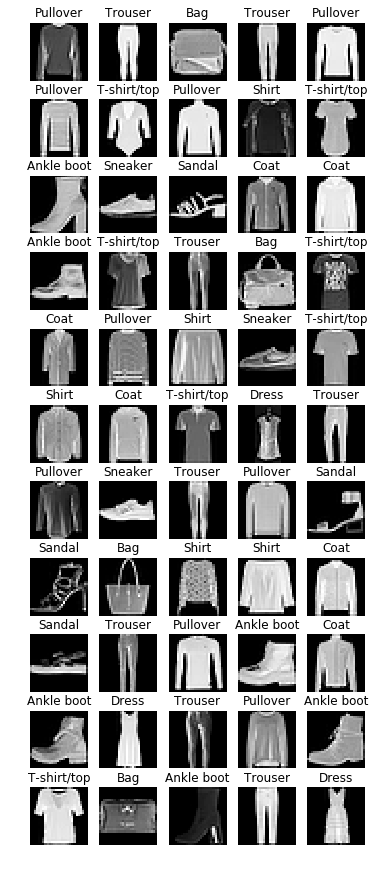

In [181]:
def tile_plot(train,imgs=55,greyscale=True,scale=False,labelling=True):
    # This function plots the images in a tiled fashion, for better visualization.
    fig = plt.figure(figsize=(8,8))
    columns = 4
    rows = 10
    fig, ax = plt.subplots(1,imgs)
    for i,j in enumerate(tfds.as_numpy(train)):
        img= j[0]
        
        label = {
        0 : 'T-shirt/top',
        1 : 'Trouser',
        2 : 'Pullover',
        3 : 'Dress',
        4 : 'Coat',
        5 : 'Sandal',
        6 : 'Shirt',
        7 : 'Sneaker',
        8 : 'Bag',
        9 : 'Ankle boot'
        }
        # if label is still just an integer
        if isinstance(j[1], np.int64):
            if labelling:
                lbl = label[j[1]]
        else:
            indice = np.where(j[1] == 1)
            indice = indice[0]
            if labelling:
                lbl = label[int(indice)]
        subax = fig.add_subplot(rows+1,columns+1,i+1)   
        subax.axis("off")
        if labelling:
            subax.set_title(lbl)

        if greyscale: #Dealing with grayscale images requires a different approach, since imshow doesn't handle them as adroitly as RGB
            if scale: # This is to visualize our normalized images. Since this doesn't conform to the standard scale, we have to define our own
                plt.imshow(np.squeeze(img),vmin=-2, vmax= 2.5,cmap="gray")
            else:
                plt.imshow(tf.cast(np.squeeze(img),tf.uint8),cmap="gray")
        else:
            plt.imshow(tf.cast(img,tf.uint8)) #cast to uint because otherwise there's an error from matplotlib
        ax[i].axis("off")
        if i == (imgs-1): 
            # this is really awkward, but sadly prefetch_datasets are quite particular about indexing.
            # converting them to numpy first might be smarter in the future
            break
    plt.subplots_adjust(top=3)
    plt.show()

tile_plot(train_ds)

In [182]:
#Build input pipeline
train_ds = train_ds.map(lambda image, label: (tf.cast(image/255, tf.float32), tf.reshape(tf.one_hot(label, 10), (-1,))))
test_ds = test_ds.map(lambda image, label: (tf.cast(image/255, tf.float32), tf.reshape(tf.one_hot(label, 10), (-1,))))

prefetch_size = tf.data.experimental.AUTOTUNE

# batching, shuffle und prefetching
train_ds = train_ds.batch(64).shuffle(buffer_size=64).prefetch(prefetch_size)
test_ds = test_ds.batch(64).shuffle(buffer_size=64).prefetch(prefetch_size)

In [183]:


def plot_performance(total_epochs, train_loss, test_loss, accuracies, timing):
    """Helper function to plot the models performance inline during and after training"""
    #clear_output(wait=True) # Clear the previous graph
    fig, ax = plt.subplots(1,2, figsize=(12,6))
    # Estimation for remaining time
    epoch = len(train_loss) - 1
    remaining_time = (timing[1] - timing[0]) * (total_epochs - epoch)
    fig.suptitle(f"Epoch {epoch} / {total_epochs} - Remaining Training Time: {time.strftime('%M:%S', time.gmtime(remaining_time))} min", fontsize=16)

    ax[0].plot(train_loss)
    ax[0].plot(test_loss)
    ax[0].legend(["training", "test"])
    ax[0].set(xlabel="Training Steps", ylabel="Loss")
    ax[1].plot(accuracies)
    ax[1].set(xlabel="Training Steps", ylabel="Accuracy", title=f"max accuracy: {max(accuracies)*100:.2f}%")

    plt.show()

In [184]:
class CNN_layer(Layer):
    """This class allows us to easily define Convolutional layers"""
    
    def __init__(self,filters,strides=1,batch_norm=True):
        super(CNN_layer, self).__init__()

        self.conv_1 = tf.keras.layers.Conv2D(filters = filters,
                                         kernel_size = 3,
                                         strides = strides,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,
                                         bias_initializer = 'zeros',
                                         kernel_regularizer = None) # tf.keras.regularizers.L2(0.01)
        self.batch_norm_1 = tf.keras.layers.BatchNormalization()                                         
        self.activ_1 = tf.keras.activations.relu

    @tf.function
    def call(self,x,training):
        x = self.conv_1(x)
        x = self.batch_norm_1(x,training=training)
        x = self.activ_1(x)
        return x


In [185]:
class Transpose_layer(Layer):
    """Transpose layers upscale featuremaps they are given."""
    
    def __init__(self,filters,stride=2,batch_norm=True):
        super(Transpose_layer, self).__init__()

        self.conv_1 = tf.keras.layers.Conv2DTranspose(filters = filters,
                                         kernel_size = 3,
                                         strides = stride,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,
                                         bias_initializer = 'zeros',
                                         kernel_regularizer = None)
        self.batch_norm_1 = tf.keras.layers.BatchNormalization()                                         
        self.activ_1 = tf.keras.activations.relu

    @tf.function
    def call(self,x,training):
        x = self.conv_1(x)
        x = self.batch_norm_1(x,training=training)
        x = self.activ_1(x)
        return x

In [186]:
class Dense_layer(Layer):
    """Transpose layers upscale featuremaps they are given."""
    
    def __init__(self,filters,batch_norm=True):
        super(Dense_layer, self).__init__()

        self.l1 = tf.keras.layers.Dense(units=7*7*16, activation=None)
        self.l2 = tf.keras.layers.BatchNormalization()                                         
        self.l3 = tf.keras.activations.relu

    @tf.function
    def call(self,x,training):
        x = self.l1(x)
        x = self.l2(x,training=training)
        x = self.l3(x)
        return x

In [187]:
class Encoder(Model):
    
    def __init__(self): #todo: consider upping filter sizes!
        super(Encoder, self).__init__()

        self.hidden = [
            CNN_layer(32,strides=2), # 14
            CNN_layer(16,strides=2), # 7x7x8
            tf.keras.layers.Flatten(),
            Dense_layer(7*7*16),
            tf.keras.layers.Dense(units=20, activation=tf.keras.activations.relu), #1x1x10
        ]

    @tf.function
    def call(self,x,training):
        for i in self.hidden:
            x = i(x,training=training)
        #for i in x:
        #        print(i.shape)
        #        break

        return x


In [188]:
class Decoder(Model):
    
    def __init__(self):
        super(Decoder, self).__init__()

        self.hidden = [
            Dense_layer(7*7*16),
            tf.keras.layers.Reshape((7,7,16)),

            Transpose_layer(16), # 4
            Transpose_layer(32), # 8
        ]

        self.conv_1 = tf.keras.layers.Conv2D(filters = 1,
                                         kernel_size = 3,
                                         strides = 1,
                                         activation = tf.keras.activations.sigmoid,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,
                                         bias_initializer = 'zeros',
                                         kernel_regularizer = None)

    @tf.function
    def call(self,x,training):
        for i in self.hidden:
            x = i(x,training=training)

        #x = tf.image.resize(x, [28,28], method=tf.image.ResizeMethod.BILINEAR, preserve_aspect_ratio=False,
        #                    antialias=False, name=None) # https://github.com/tensorflow/tensorflow/issues/6720

        x = self.conv_1(x)

        #for i in x:
        #        print(i.shape)
        #        break

        return x

In [189]:
class Auto_encoder(Model):
    
    def __init__(self):
        super(Auto_encoder, self).__init__()

        self.hidden = [
            Encoder(),
            Decoder(),
        ]
    
    @tf.function
    def call(self,x,training):
        x = self.hidden[0](x,training)
        # print("Embedding is ",x)
        x = self.hidden[1](x,training)
        return x

In [190]:
def train_step(model, data, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  
  with tf.GradientTape() as tape:
    prediction = model(data, training = True)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  
  return loss 


def test_step(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (data, target) in test_data:
    target = data
    prediction = model(data, training = False)
    
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)

    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [176]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 30
learning_rate = tf.optimizers.schedules.ExponentialDecay(0.001, 5000, 0.97, staircase=True) #polynomial?
running_average_factor = 0.95

# Initialize the model.
model = Auto_encoder()


# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
# loss_func = tf.keras.losses.BinaryCrossentropy()
loss_func = tf.keras.losses.MeanSquaredError()

# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []
test_losses = []
test_accuracies = []

#
t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)
print(f"Training started at {current_time}.")

#testing once before we begin
test_loss, test_accuracy = test_step(model, test_ds, loss_func)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test_step(model, train_ds, loss_func)
train_losses.append(train_loss)
print(model.summary())

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    start = time.perf_counter()
    print('Epoch: __ ' + str(epoch))

    #training (and checking in with training)
    running_average = 0
    for (data,target) in train_ds:
        #train_loss = train_step(model, data, target, loss_func, optimizer)
        train_loss = train_step(model, data, data, loss_func, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    #testing
    test_loss, test_accuracy = test_step(model, test_ds, loss_func)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    
    end = time.perf_counter()
    plot_performance(num_epochs, train_losses, test_losses, test_accuracies, (start, end))

t2 = time.localtime()
current_time2 = time.strftime("%H:%M:%S", t)
t_delta = time.mktime(t2)-time.mktime(t)
print(f"Training ended at {current_time}. Duration was {t_delta/60:.2f} minutes.")


# images = model(data,training=False).numpy()
# tile_plot(images,labelling=False)

Training started at 15:23:07.
Model: "auto_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  639412    
_________________________________________________________________
decoder (Decoder)            multiple                  27041     
Total params: 666,453
Trainable params: 663,125
Non-trainable params: 3,328
_________________________________________________________________
None
Epoch: __ 0


KeyboardInterrupt: 

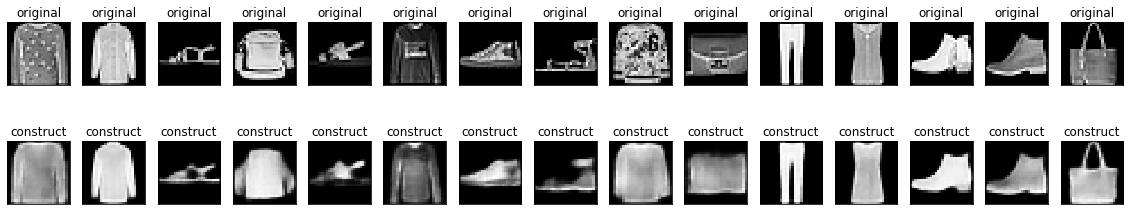

In [148]:
images = model(data,training=False).numpy()

x_test = list(map(lambda x: x[0], test_ds))
x_test = tfds.as_numpy(test_ds)
n = 15
plt.figure(figsize=(20, 4))
for i in range(n):
  #display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(np.squeeze(data[i]))
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  #ax = plt.subplot(2, n, i + 1)
  # print(images[i].shape)
  plt.imshow(np.squeeze(images[i]))
  plt.title("construct")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()